In [14]:
## NOTE - when running on the training data, this uses up to ~3GB of RAM on my machine
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
OUTPUT_DATA = False

In [3]:
scriptDir = os.getcwd() # Assumes that script is executed from its actual location
relPath = r"../data/" # And data is located in a 'data' folder in the same parent directory as 'code' folder
trainFilePath = os.path.join(scriptDir, relPath,"train.csv")
valFilePath = os.path.join(scriptDir, relPath,"validation.csv")
sampleFilePath = os.path.join(scriptDir, relPath,"sample.csv")
relPathOutput = r"../output/"
outputFolderPath = os.path.join(scriptDir, relPathOutput)

In [49]:
# Load data
df = pd.read_csv(trainFilePath, sep=',',header=0, quotechar='"')

In [50]:
# min and max from single agent random bidding test
# widened a little for testing
minBid = 21
maxBid = 24

In [51]:
# ASSUMPTION THAT THE OTHER AGENTS HAVE NO BUDGET CONSTRAINT
# i.e. they continue bidding in the same way indefinitely
def evalRandomBidMulti(df, low, high, budget=6250*1000, repeat=1, agents=2):
    # number of agents must be 2 or more
    results = np.zeros((repeat, 6))
    for iteration in range(repeat):    
        # generate series of bids within the provided bounds for the test agent   
        bidValues = np.random.randint(low, high, (df.shape[0],))
        # and for all the others
        bidValuesOther = np.random.randint(low, high, (df.shape[0],agents-1))
        # get the max of the other bid values (needed for payprice)
        bidValuesOtherMax = np.max(bidValuesOther, axis=1)
        # now check if our agent won outright (not a draw)
        won = np.where(bidValues > bidValuesOtherMax, True, False)
        # for tiebreaks, need to know how many others bid the same as our test agent
        ties = np.where(bidValues == bidValuesOtherMax, True, False)
        otherBidTies = np.where(bidValuesOther == bidValues.reshape(df.shape[0],1), 1, 0)
        otherBidTiesCount = np.sum(otherBidTies, axis=1)
        otherBidTiesCount = np.where(ties, otherBidTiesCount, 0) # remove if not the max
        # after calculating how many other agents also bid the winning amount, 
        # need to randomly assign the win to either our test agent or the others
        # so generate vector of random numbers between 0 and 1
        # if the number is under (or equal to) 1/agentsWithMaxBid, then win, else lose
        prob = np.random.random(size=(df.shape[0],))
        threshold = 1.0 / (otherBidTiesCount + 1)
        wonDraw = np.where(np.logical_and(ties, prob < threshold), True, False)
        wonFinal = np.where(np.logical_or(won, wonDraw), True, False)
    
        # pay price (second price auction)
        payprice = np.where(wonFinal, bidValuesOtherMax, 0)
    
        # remove everything we wouldn't win, we don't care about it anymore
        dfWon = df[['bidid', 'click']][wonFinal].copy()
        dfWon['payprice'] = payprice[wonFinal] # second price auction
        
        # now evaluate sequentially to see what the results are
        # first random sample (taking everything without replacement equivalent to a shuffle)
        # although if only do 1 test, then don't
        #if repeat > 1:
        #    dfWon = dfWon.sample(frac=1)
        # Commenting this out for now and just letting the random bidding change each iteration
        
        # now create cumulative spend
        dfWon['cumSpend'] = dfWon['payprice'].cumsum()
        dfWon['cumSpendLead'] = dfWon['cumSpend'].shift(1, fill_value=0)
        dfRes = dfWon[dfWon['cumSpendLead'] <= budget]
        # and get stats
        numClicks = dfRes['click'].sum()
        numImps = dfRes['bidid'].count()
        totalCPM = dfRes['payprice'].sum()
        spend = totalCPM / 1000

        if numImps > 0:
            CTR = numClicks / numImps
            aveCPM = totalCPM / numImps
        else:
            CTR = np.NaN
            aveCPM = np.NaN

        if numClicks > 0:
            aveCPC = spend / numClicks
        else:
            aveCPC = np.NaN
        
        results[iteration,:] = np.array([numImps, numClicks, CTR, spend, aveCPM, aveCPC])
        
    resultsMean = np.mean(results, axis=0)
        
    return resultsMean

In [54]:
results = list()
for agents in range(50,101):
    stats = evalRandomBidMulti(df, minBid, maxBid, repeat=5, agents=agents)
    results.append(np.hstack(([minBid, maxBid, agents], stats)))
results = np.array(results)

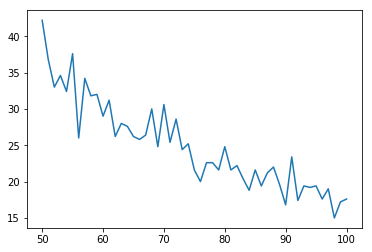

In [55]:
# Clicks
plt.plot(results[:,2], results[:,4]);

In [56]:
# Now let's look at the validation set
valDf = pd.read_csv(valFilePath, sep=',',header=0, quotechar='"')

In [57]:
resultsVal = list()
for agents in range(50,101):
    stats = evalRandomBidMulti(valDf, minBid, maxBid, repeat=20, agents=agents)
    resultsVal.append(np.hstack(([minBid, maxBid, agents], stats)))
resultsVal = np.array(resultsVal)

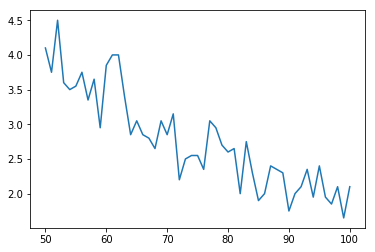

In [58]:
# Clicks
plt.plot(resultsVal[:,2], resultsVal[:,4]);

In [93]:
dfRes = pd.DataFrame(results[:,2]).reset_index().rename({0: 'n'}, axis='columns')
dfRes['clicks'] = results[:,4]

In [94]:
dfResVal = pd.DataFrame(resultsVal[:,2]).reset_index().rename({0: 'n'}, axis='columns')
dfResVal['clicks'] = resultsVal[:,4]

In [95]:
dfRes['n'] = dfRes['n'].astype('int')
dfResVal['n'] = dfResVal['n'].astype('int')

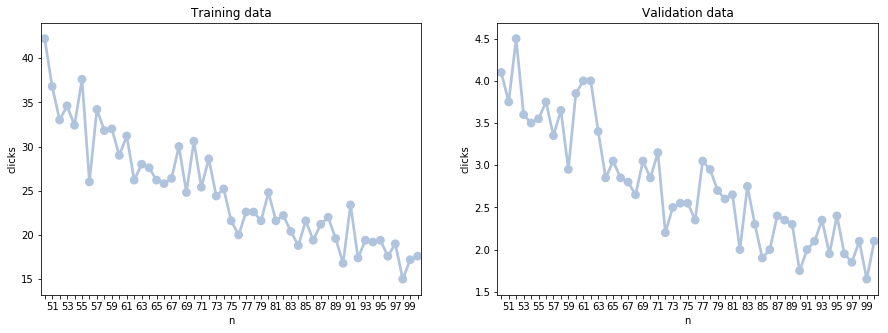

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.pointplot(x='n', y='clicks', data=dfRes, color='lightsteelblue', ax=axes[0])
sns.pointplot(x='n', y='clicks', data=dfResVal, color='lightsteelblue', ax=axes[1])
for ax in axes:
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)
axes[0].set_title('Training data');
axes[1].set_title('Validation data');


In [109]:
fig.savefig(os.path.join(outputFolderPath, 'multiRandom.png'));